## MRI Brain Tumour Segmentation using U-Net Deep Learning Model

References:
- https://arxiv.org/pdf/1505.04597
- https://github.com/adityajn105/brain-tumor-segmentation-unet/blob/master/brain_tumor_segmentation.ipynb

### Import necessary libraries

In [72]:
import matplotlib.pyplot as plt
import keras_tuner as kt

from utils import *
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization, Flatten, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

### Data Preperation

In [73]:
# Parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
NUM_CLASSES = 4 

# Create ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale the image to 0-1
    rotation_range=10,      # Random rotation up to 10 degrees
    width_shift_range=0.1,  # Random horizontal shift by up to 10% of image width
    height_shift_range=0.1, # Random vertical shift by up to 10% of image height
    # zoom_range=0.1,         # Random zooming by up to 10%
    # zoom_range=[.9,1.1],    # Random zooming by up to 10% or down to 10%
    horizontal_flip=True,   # Random horizontal flipping
    fill_mode='nearest',    # Fill mode for pixels outside the input boundaries
    validation_split=0.2    # Split data into training and validation
)

# Create ImageDataGenerator for validation data
valid_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale the image to 0-1
    validation_split=0.2    # Split data into training and validation
)

# Create training generator
train_generator = train_datagen.flow_from_directory(
    DATASET_FOLDER,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=19032024
)

# Create validation generator
validation_generator = valid_datagen.flow_from_directory(
    DATASET_FOLDER,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=19032024
)

# Check the shape of your training data
for images, labels in train_generator:
    print("Shape of images batch:", images.shape)
    print("Shape of labels batch:", labels.shape)
    break

Found 380 images belonging to 4 classes.
Found 95 images belonging to 4 classes.
Shape of images batch: (32, 224, 224, 3)
Shape of labels batch: (32, 4)


In [74]:
# Get class names
class_names = list(train_generator.class_indices.keys())
print("Training classes:", class_names)
class_names = list(validation_generator.class_indices.keys())
print("Validation classes:", class_names)

Training classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Validation classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


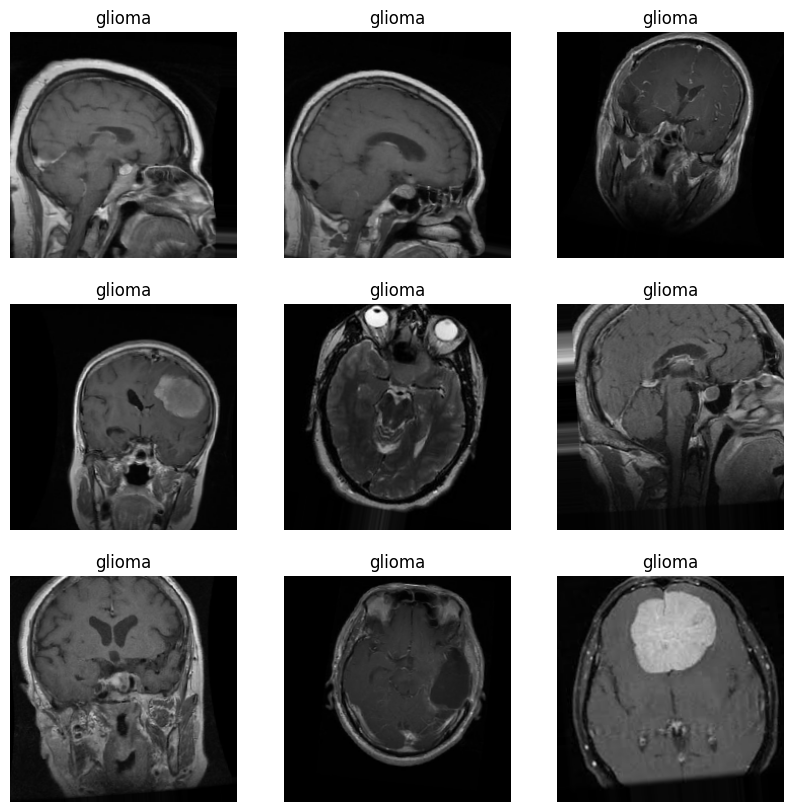

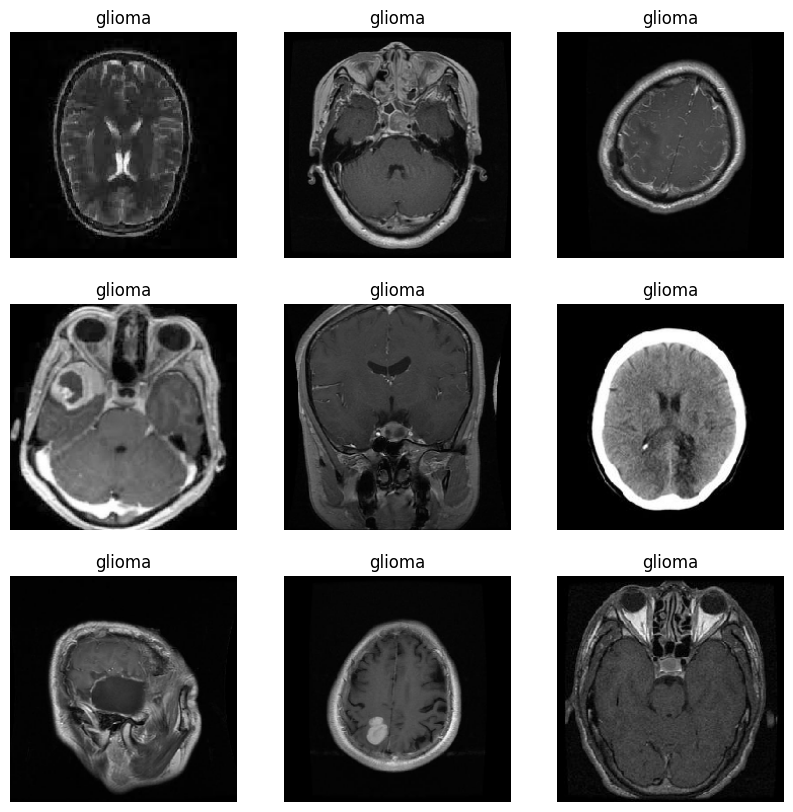

In [75]:
# Preview training dataset
sample_data_train = train_generator.__getitem__(1)[0]
sample_label_train = train_generator.__getitem__(1)[1]

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_data_train[i])
    plt.title(class_names[np.argmax(sample_label_train[i].argmax())])
    plt.axis("off")

# Preview validation dataset
sample_data_validation = validation_generator.__getitem__(1)[0]
sample_label_validation = validation_generator.__getitem__(1)[1]

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_data_validation[i])
    plt.title(class_names[np.argmax(sample_label_validation[i].argmax())])
    plt.axis("off")

### Model Creation

In [76]:
IMG_DIM = (IMG_HEIGHT, IMG_WIDTH, 3)

def conv2d_block(input_tensor, n_filters, kernel_size=(3,3), name="contraction"):
    "Add 2 conv layers"
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
               padding='same', activation="relu", name=name+'_1')(input_tensor)
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
               padding='same', activation="relu", name=name+'_2')(x)
    return x
  

def build_model(hp):
    inp = Input(shape=IMG_DIM)

    # Encoder
    d1 = conv2d_block(inp, hp.Int('filters_1', 32, 128, step=32), name="contraction_1")
    p1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d1)
    p1 = BatchNormalization(momentum=0.8)(p1)
    p1 = Dropout(hp.Float('dropout_1', 0.1, 0.3, step=0.1))(p1)

    d2 = conv2d_block(p1, hp.Int('filters_2', 64, 256, step=64), name="contraction_2")
    p2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d2)
    p2 = BatchNormalization(momentum=0.8)(p2)
    p2 = Dropout(hp.Float('dropout_2', 0.1, 0.3, step=0.1))(p2)

    d3 = conv2d_block(p2, hp.Int('filters_3', 128, 512, step=128), name="contraction_3")
    p3 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d3)
    p3 = BatchNormalization(momentum=0.8)(p3)
    p3 = Dropout(hp.Float('dropout_3', 0.1, 0.3, step=0.1))(p3)

    d4 = conv2d_block(p3, hp.Int('filters_4', 256, 512, step=256), name="contraction_4")
    p4 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d4)
    p4 = BatchNormalization(momentum=0.8)(p4)
    p4 = Dropout(hp.Float('dropout_4', 0.1, 0.3, step=0.1))(p4)

    d5 = conv2d_block(p4, hp.Int('filters_5', 256, 512, step=256), name="contraction_5")

    # Decoder
    u1 = Conv2DTranspose(hp.Int('filters_5', 256, 512, step=256), (3, 3), strides=(2, 2), padding='same')(d5)
    u1 = concatenate([u1, d4])
    u1 = Dropout(hp.Float('dropout_5', 0.1, 0.3, step=0.1))(u1)
    c1 = conv2d_block(u1, hp.Int('filters_4', 256, 512, step=256), name="expansion_1")

    u2 = Conv2DTranspose(hp.Int('filters_4', 256, 512, step=256), (3, 3), strides=(2, 2), padding='same')(c1)
    u2 = concatenate([u2, d3])
    u2 = Dropout(hp.Float('dropout_4', 0.1, 0.3, step=0.1))(u2)
    c2 = conv2d_block(u2, hp.Int('filters_3', 128, 512, step=128), name="expansion_2")

    u3 = Conv2DTranspose(hp.Int('filters_3', 128, 512, step=128), (3, 3), strides=(2, 2), padding='same')(c2)
    u3 = concatenate([u3, d2])
    u3 = Dropout(hp.Float('dropout_3', 0.1, 0.3, step=0.1))(u3)
    c3 = conv2d_block(u3, hp.Int('filters_2', 64, 256, step=64), name="expansion_3")

    u4 = Conv2DTranspose(hp.Int('filters_2', 64, 256, step=64), (3, 3), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, d1])
    u4 = Dropout(hp.Float('dropout_2', 0.1, 0.3, step=0.1))(u4)
    c4 = conv2d_block(u4, hp.Int('filters_1', 32, 128, step=32), name="expansion_4")

    # Final classification layer
    flattened = Flatten()(c4)
    out = Dense(NUM_CLASSES, activation='softmax', name="output")(flattened)

    unet = Model(inp, out)

    unet.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

    return unet

# Test if the model builds successfully
build_model(kt.HyperParameters())

<Functional name=functional_3, built=True>

### Fine Tuning

In [77]:
# Tuning settings
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=50,
                     directory="hyperparameter-search",
                     project_name="brain-tumor-classification",
)

# Perform search
tuner.search(train_generator, epochs=2, validation_data=validation_generator)

Trial 50 Complete [00h 55m 59s]
val_accuracy: 0.2526315748691559

Best val_accuracy So Far: 0.7789473533630371
Total elapsed time: 1d 13h 18m 21s

Search: Running Trial #51

Value             |Best Value So Far |Hyperparameter
32                |64                |filters_1
0.2               |0.2               |dropout_1
192               |192               |filters_2
0.2               |0.1               |dropout_2
384               |256               |filters_3
0.2               |0.1               |dropout_3
512               |512               |filters_4
0.2               |0.1               |dropout_4
256               |512               |filters_5
0.1               |0.1               |dropout_5
0.0017311         |0.00012093        |learning_rate
6                 |50                |tuner/epochs
0                 |17                |tuner/initial_epoch
2                 |3                 |tuner/bracket
0                 |3                 |tuner/round

Epoch 1/6
 2/12 ━━━━━━━━━━━━━

KeyboardInterrupt: 

In [79]:
# Retrieve the best hyperparameters found
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"filters_1: {best_hps.get('filters_1')}")
print(f"dropout_1: {best_hps.get('dropout_1')}")
print(f"filters_2: {best_hps.get('filters_2')}")
print(f"dropout_2: {best_hps.get('dropout_2')}")
print(f"filters_3: {best_hps.get('filters_3')}")
print(f"dropout_3: {best_hps.get('dropout_3')}")
print(f"filters_4: {best_hps.get('filters_4')}")
print(f"dropout_4: {best_hps.get('dropout_4')}")
print(f"filters_5: {best_hps.get('filters_5')}")
print(f"dropout_5: {best_hps.get('dropout_5')}")
print(f"learning_rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
filters_1: 64
dropout_1: 0.2
filters_2: 192
dropout_2: 0.1
filters_3: 256
dropout_3: 0.1
filters_4: 512
dropout_4: 0.1
filters_5: 512
dropout_5: 0.1
learning_rate: 0.00012093314183885964


### Model Training

In [82]:
# Create callbacks
model_checkpoint = ModelCheckpoint('./models/unet_best_checkpoint.keras', save_best_only=True, 
                                    monitor='val_loss', mode='min', verbose=1)
# reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Define callback list
callback_list = [model_checkpoint]

model = tuner.hypermodel.build(best_hps)

# Train the model
hist = model.fit(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback_list)

# Export latest model
model.save(MODEL_FILE)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.2939 - loss: 16.2539 
Epoch 1: val_loss improved from inf to 1.28541, saving model to ./models/unet_best_checkpoint.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 390s 32s/step - accuracy: 0.2974 - loss: 15.8234 - val_accuracy: 0.4842 - val_loss: 1.2854
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.4909 - loss: 1.5483 
Epoch 2: val_loss did not improve from 1.28541
12/12 ━━━━━━━━━━━━━━━━━━━━ 389s 32s/step - accuracy: 0.4908 - loss: 1.5381 - val_accuracy: 0.4421 - val_loss: 1.3135
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.5494 - loss: 1.1926 
Epoch 3: val_loss improved from 1.28541 to 1.01523, saving model to ./models/unet_best_checkpoint.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 376s 31s/step - accuracy: 0.5501 - loss: 1.1854 - val_accuracy: 0.4316 - val_loss: 1.0152
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.6265 - loss: 0.9549 
Epoch 4: val_loss improved from 1.01523 to 0.89265, savi

### Model Evaluation

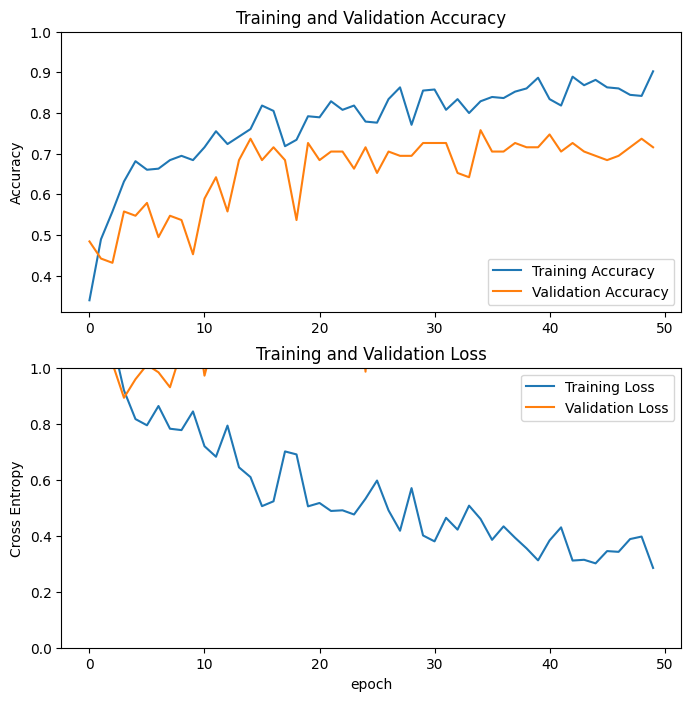

3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - accuracy: 0.6860 - loss: 1.9478
Test Accuracy : 0.7157894968986511
Test Loss : 2.3022987842559814
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - accuracy: 0.6860 - loss: 2.5814
Validation Accuracy: 0.72


In [84]:
# View training metrics across epochs
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test metrics
loss, accuracy = model.evaluate(validation_generator)
print('Test Accuracy :', accuracy)
print('Test Loss :', loss)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy:.2f}')


In [ ]:
""" Model Performance """
# Load the best model
# model = keras.models.load_model('./models/unet_best_checkpoint.keras')

# Load the last model
model = keras.models.load_model('./models/unet_model.keras')

In [86]:
# Load images and labels
images, labels, class_names = load_data(DATASET_FOLDER)

# Train-Test split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=1234)

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [87]:
# Initialise predictions
list_train_pred = []
list_test_pred = []

for image_path in x_train:
    list_train_pred.append(predict_class(image_path, model, class_names, (IMG_HEIGHT, IMG_WIDTH), verbose_output=1))
    
for image_path in x_test:
    list_test_pred.append(predict_class(image_path, model, class_names, (IMG_HEIGHT, IMG_WIDTH), verbose_output=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [88]:
# Get model's training performance
training_results = classifier_metrics(list(y_train), list_train_pred, print_results=True)

Accuracy: 0.2236842105263158
Precision: 0.06019830028328612
Recall: 0.22135416666666666
F1 Score: 0.09465478841870824
Matthews Correlation Coefficient (MCC): -0.0920029775306798
Cohen's Kappa: -0.03873239436619724
Hamming Loss: 0.7763157894736842

Confusion Matrix:
 [[ 0 96  0  0]
 [11 85  0  0]
 [ 2 90  0  0]
 [14 82  0  0]]

Classification Report:
               precision    recall  f1-score   support

      glioma       0.00      0.00      0.00        96
  meningioma       0.24      0.89      0.38        96
     notumor       0.00      0.00      0.00        92
   pituitary       0.00      0.00      0.00        96

    accuracy                           0.22       380
   macro avg       0.06      0.22      0.09       380
weighted avg       0.06      0.22      0.10       380





/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

In [90]:
# Get model's test performance
test_results = classifier_metrics(list(y_test), list_test_pred, print_results=True)

Accuracy: 0.25263157894736843
Precision: 0.10627340823970038
Recall: 0.25
F1 Score: 0.11843657817109145
Matthews Correlation Coefficient (MCC): 0.0
Cohen's Kappa: 0.0
Hamming Loss: 0.7473684210526316

Confusion Matrix:
 [[ 1 23  0  0]
 [ 1 23  0  0]
 [ 0 23  0  0]
 [ 4 20  0  0]]

Classification Report:
               precision    recall  f1-score   support

      glioma       0.17      0.04      0.07        24
  meningioma       0.26      0.96      0.41        24
     notumor       0.00      0.00      0.00        23
   pituitary       0.00      0.00      0.00        24

    accuracy                           0.25        95
   macro avg       0.11      0.25      0.12        95
weighted avg       0.11      0.25      0.12        95





/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(